# Ludo Project

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

In [88]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  image = PIL.Image.fromarray(a)
  new_image = image.resize((250, 400))
  display(new_image)

In [89]:
#Video.from_file('videos\IMG_1912.mp4')
board = cv2.VideoCapture('videos\IMG_1912.mp4')
if board.isOpened():
    print('Video loaded')

board_width = int(board.get(3))
board_height = int(board.get(4))

print(board_height, board_width)

board_fps = board.get(cv2.CAP_PROP_FPS)
print(board_fps)

Video loaded
1920 1080
29.97002997002997


In [8]:
board.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = board.read()
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)
roi = frame[y:y+h, x:x+w]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

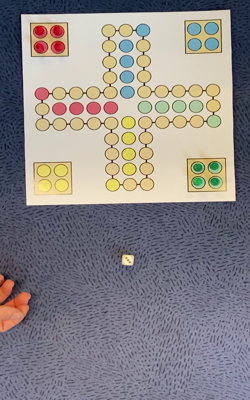

In [15]:
imshow(frame)

[] (227.25, 852.75)
[(227.25, 852.75)] (892.25, 838.5)
[(227.25, 852.75), (892.25, 838.5)] (212.5, 190.0)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0)] (213.0, 189.25)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0)] (877.25, 174.5)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0), (877.25, 174.5)] (877.0, 174.5)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0), (877.25, 174.5)] (553.5, 516.25)


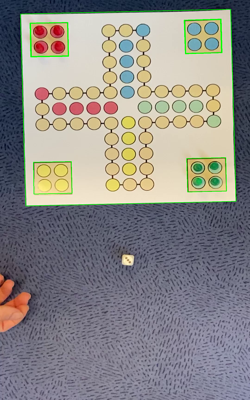

In [90]:
from scipy.spatial.distance import cdist

def closest_node(node, nodes):
    print(nodes, node)
    if len(nodes) == 0:
        return 0, np.Inf
    distances = cdist([node], nodes)
    return nodes[distances.argmin()], distances.min()

def add_shape(box, dict_boxes):
    center = np.mean(box, axis=0)
    center = (center[0], center[1])
    closest, distance = closest_node(center, list(dict_boxes.keys()))
    if distance > 100:
        dict_boxes[center] = box
    else:
        dict_boxes[closest] = (dict_boxes[closest] + box)/2

boxes = dict()
def find_squares(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, 100, 255, cv2.THRESH_BINARY_INV)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    #close = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, kernel, iterations=1) # good for token spotting
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    cnts, _ = cv2.findContours(close, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    #for contour, hier in zip(cnts, hierarchy[0]):
    for contour in cnts:
        approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
        x, y , w, h = cv2.boundingRect(approx)
        aspectRatio = float(w)/h
        if  aspectRatio >0.9 and aspectRatio < 1.1 and cv2.contourArea(contour) > 100 and len(approx)< 10:
            ## BEGIN - draw rotated rectangle
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            #boxes[x] = box
            add_shape(box, boxes)
            cv2.drawContours(image,[box],0,(0,255,0),2)
        
        # TODO cluster into 5 subcategories: board, base1, base2, base3, base4
    imshow(image)
    


def base_recognition(frame):
    pass


def board_recognition(frame):
    pass


find_squares(frame)

In [91]:
boxes

{(227.25,
  852.75): array([[144, 778],
        [308, 775],
        [311, 927],
        [146, 931]], dtype=int64),
 (892.25,
  838.5): array([[806, 760],
        [975, 756],
        [978, 917],
        [810, 921]], dtype=int64),
 (212.5,
  190.0): array([[130.5, 111. ],
        [292. , 107.5],
        [295. , 268.5],
        [133.5, 271.5]]),
 (877.25,
  174.5): array([[796.5,  96.5],
        [953.5,  92.5],
        [957.5, 252.5],
        [801. , 256.5]]),
 (553.5,
  516.25): array([[  88,   67],
        [ 996,   44],
        [1019,  966],
        [ 111,  988]], dtype=int64)}

as seen below, camshift is not the best solution, the best way of getting the case coordinates is seeing if the board shifts and then recalculating the positions

TODO:
1. if hand is in picture
2. recalculation of board coordinates
3. tracing tokens

### Deprecated

In [79]:
board_track = cv2.VideoWriter('./slow_board_small_meanshift.avi', cv2.VideoWriter_fourcc(*'DIVX'), board_fps, (board_width, board_height))
board.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = board.read()
x1, y1 = list(boxes.values())[-1][0] 
x4, y4 = list(boxes.values())[-1][3] 
track_window = (x1, y1, x4, y4)
roi = frame[y:y+h, x:x+w]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

while board.isOpened():
    ret, frame = board.read()


    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        x1, y1, x4, y4 = track_window
        board_track.write(cv2.drawContours(frame,[list(boxes.values())[-1]],0,(0,255,255),2))
    else:
        break

board_track.release()

In [80]:
!ffmpeg -hide_banner -loglevel error -i slow_board_small_meanshift.avi -y slow_board_small_meanshift.mp4

In [81]:
Video.from_file('./slow_board_small_meanshift.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [132]:
x1, y1 = list(boxes.values())[-1][0] #1
x2, y2 = list(boxes.values())[-1][1] 
x3, y3 = list(boxes.values())[-1][2] 
x4, y4 = list(boxes.values())[-1][3] 
boxes


{(227.25,
  852.75): array([[144, 778],
        [308, 775],
        [311, 927],
        [146, 931]], dtype=int64),
 (892.25,
  838.5): array([[806, 760],
        [975, 756],
        [978, 917],
        [810, 921]], dtype=int64),
 (212.5,
  190.0): array([[130.5, 111. ],
        [292. , 107.5],
        [295. , 268.5],
        [133.5, 271.5]]),
 (877.25,
  174.5): array([[796.5,  96.5],
        [953.5,  92.5],
        [957.5, 252.5],
        [801. , 256.5]]),
 (553.5,
  516.25): array([[  88,   67],
        [ 996,   44],
        [1019,  966],
        [ 111,  988]], dtype=int64)}

67

(88, 44, 931, 944)


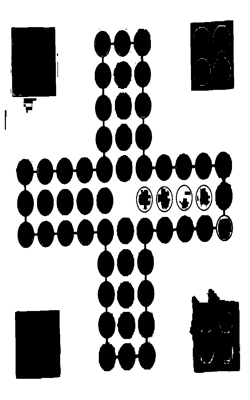

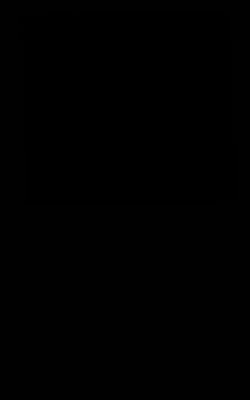

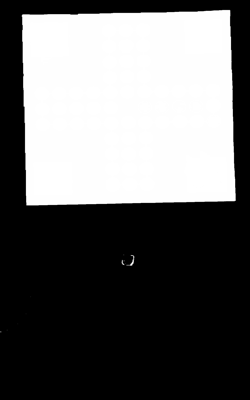

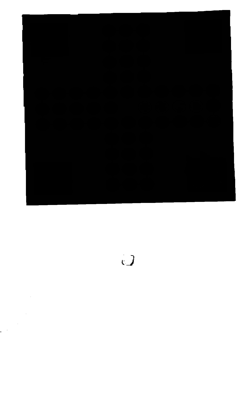

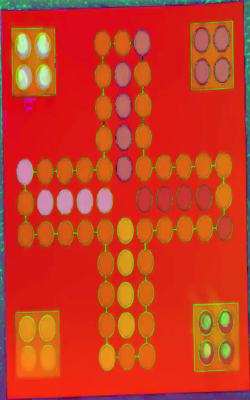

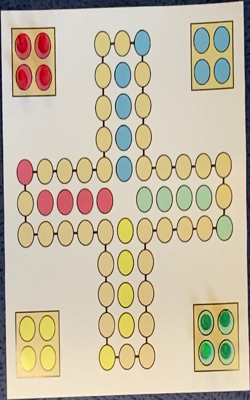

(944, 931, 3) (944, 931)


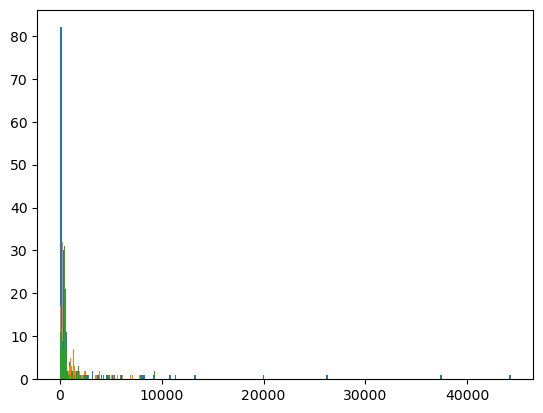

In [282]:
board.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = board.read()
x, y, w, h = x1, y2, x3- x1, y4 - y2 # simply hardcoded the values
track_window = (x, y, w, h)
roi = frame[y:y+h, x:x+w]
print(track_window)
hsv=  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 0., 150.)), np.array((50.,55.,255.)))

# Floodfill from point (0, 0)

mask_frame = cv2.inRange(hsv, np.array((0., 0., 150.)), np.array((50.,55.,255.)))// 255
h, w = mask_frame.shape[:2]
h_roi, w_roi = mask.shape[:2]
fill_mask = np.zeros((h+2, w+2), np.uint8)
fill_mask_roi = np.zeros((h_roi+2, w_roi+2), np.uint8)
cv2.floodFill(mask_frame, fill_mask, (0, 0), 255)
cv2.floodFill(mask, fill_mask_roi, (0, 0), 255)
im_floodfill_inv = cv2.bitwise_not(mask_frame)
im_floodfill_inv_roi = cv2.bitwise_not(mask)
imshow(mask)
imshow(fill_mask)
imshow(im_floodfill_inv)
imshow(mask_frame)
imshow(hsv_roi)
imshow(roi)
print(hsv_roi.shape, (im_floodfill_inv_roi).shape)
roi_hist_0 = cv2.calcHist([hsv_roi], [0], im_floodfill_inv_roi, [180], [0, 180])
roi_hist_1 = cv2.calcHist([hsv_roi], [1], im_floodfill_inv_roi, [255], [0, 255])
roi_hist_2 = cv2.calcHist([hsv_roi], [2], im_floodfill_inv_roi, [255], [0, 255])
plt.hist(roi_hist_0, bins = 256)
cv2.normalize(roi_hist_0, roi_hist_0, 0, 180, cv2.NORM_MINMAX)
plt.hist(roi_hist_1, bins = 256)
cv2.normalize(roi_hist_1, roi_hist_1, 0, 255, cv2.NORM_MINMAX)
plt.hist(roi_hist_2, bins = 256)
cv2.normalize(roi_hist_2, roi_hist_2, 0, 255, cv2.NORM_MINMAX)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 150, 10 )

In [ ]:
# TODO : dokładny tracking planszy nie ma sensu najlepiej sprawdzić przesunięcie bieli i wtedy wykryć na now

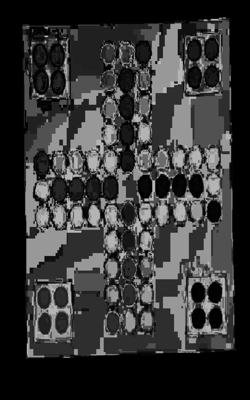

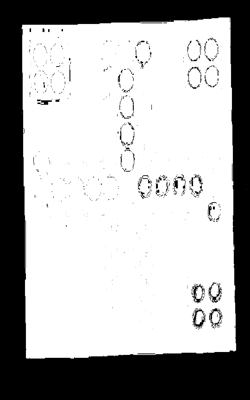

2  ((552.0, 520.5), (1040.912841796875, 1058.1939697265625), 10.95718002319336) (40, 0, 1024, 1041)


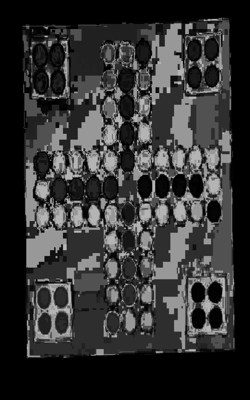

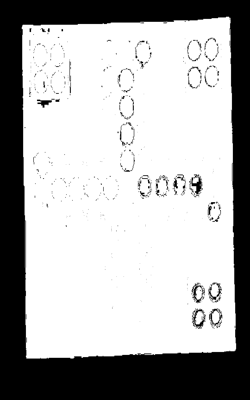

2  ((552.5, 519.5), (1039.6182861328125, 1058.2493896484375), 11.481156349182129) (42, 0, 1021, 1039)


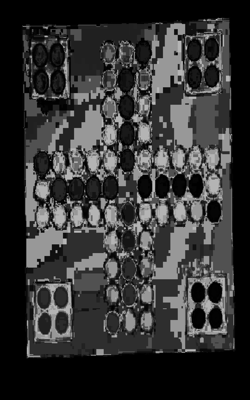

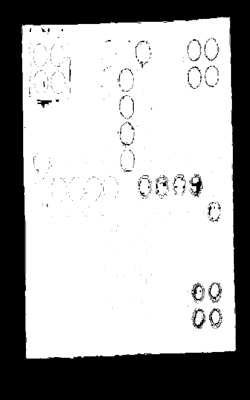

2  ((552.5, 520.5), (1039.893798828125, 1057.80908203125), 10.891132354736328) (41, 0, 1023, 1041)


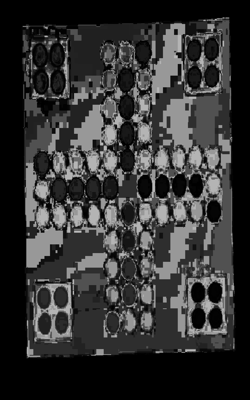

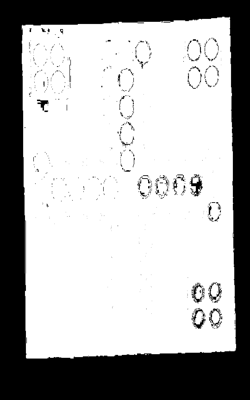

2  ((552.0, 519.0), (1039.7359619140625, 1057.842041015625), 11.746999740600586) (42, 0, 1020, 1038)


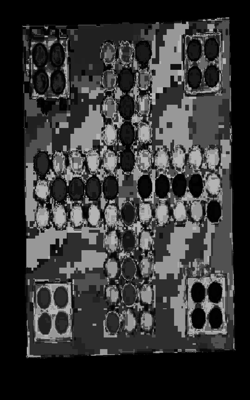

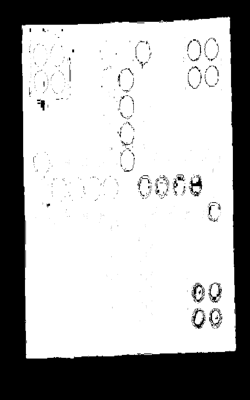

2  ((552.0, 519.0), (1040.264404296875, 1058.342041015625), 11.88743782043457) (42, 0, 1020, 1038)


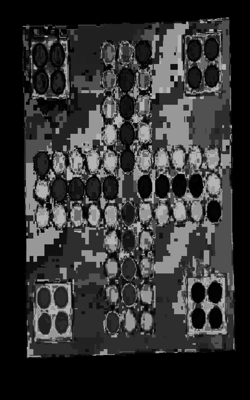

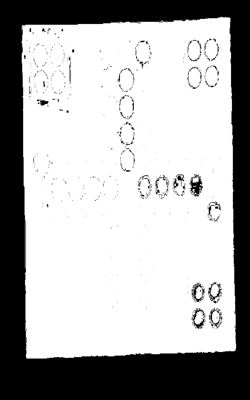

2  ((552.5, 519.5), (1039.7408447265625, 1058.1697998046875), 11.524643898010254) (42, 0, 1021, 1039)


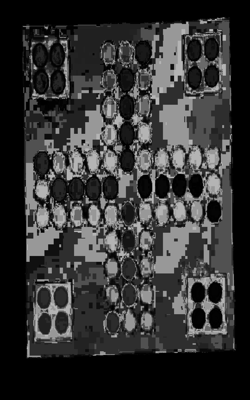

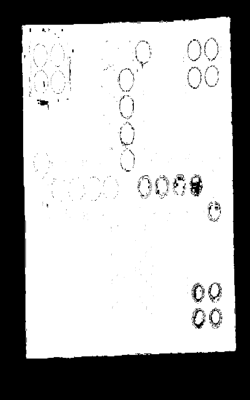

2  ((552.5, 519.5), (1040.0008544921875, 1058.483154296875), 11.988357543945312) (43, 1, 1019, 1037)


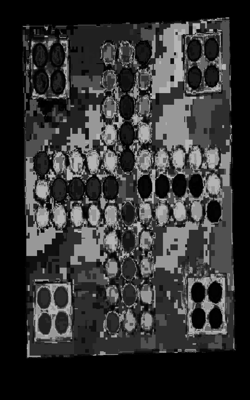

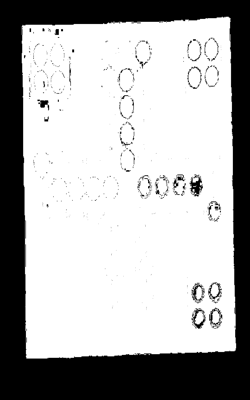

2  ((552.5, 519.0), (1039.3834228515625, 1058.4031982421875), 13.346879005432129) (46, 3, 1013, 1032)


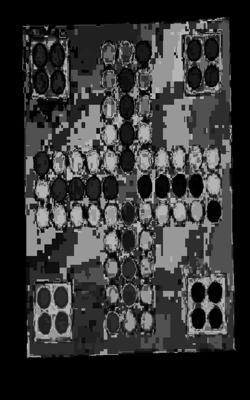

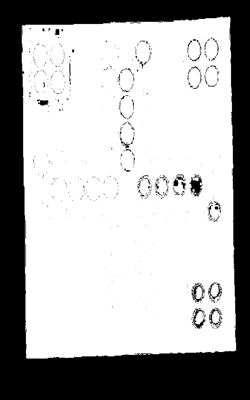

2  ((552.5, 519.0), (1040.1610107421875, 1058.5989990234375), 11.987051010131836) (43, 0, 1019, 1038)


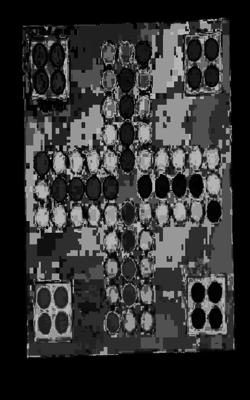

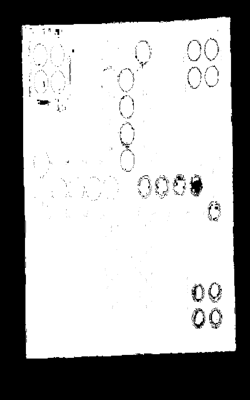

2  ((552.5, 519.0), (1039.26806640625, 1058.364501953125), 12.915292739868164) (45, 2, 1015, 1034)


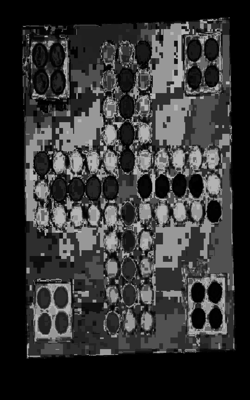

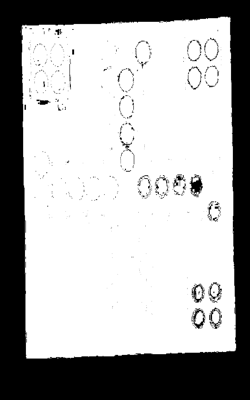

2  ((552.0, 519.0), (1039.6468505859375, 1058.4091796875), 12.797516822814941) (44, 2, 1016, 1034)


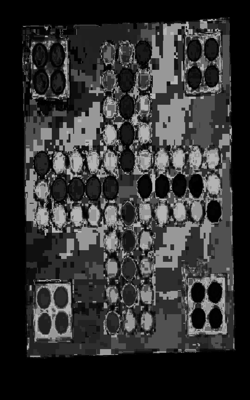

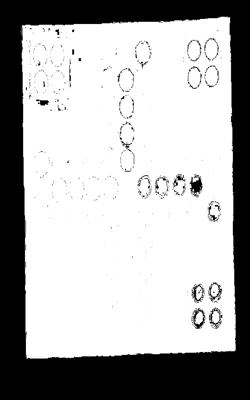

2  ((552.5, 519.0), (1039.06298828125, 1058.2933349609375), 13.816622734069824) (47, 4, 1011, 1030)


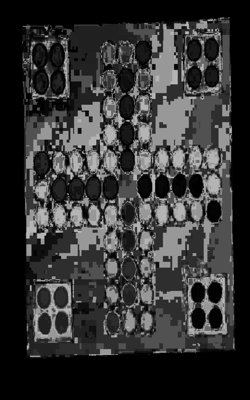

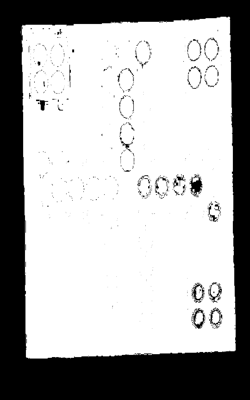

2  ((552.5, 519.5), (1039.594482421875, 1058.521240234375), 12.4898042678833) (44, 2, 1017, 1035)


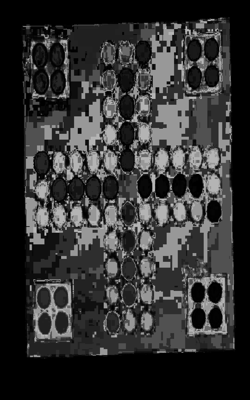

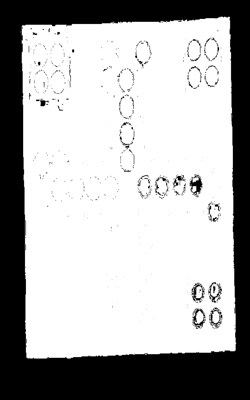

2  ((552.5, 519.0), (1039.257568359375, 1058.125), 12.864362716674805) (45, 2, 1015, 1034)


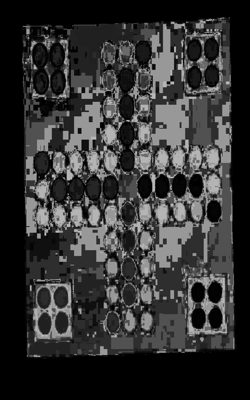

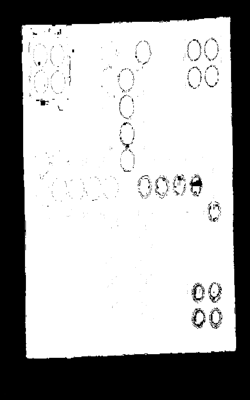

2  ((552.5, 519.0), (1039.4639892578125, 1058.328369140625), 12.390528678894043) (44, 1, 1017, 1036)


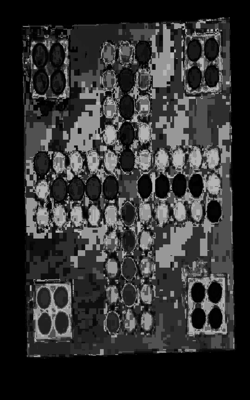

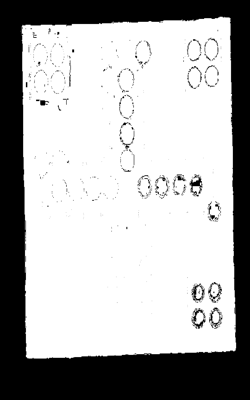

2  ((552.5, 519.0), (1039.044189453125, 1058.456298828125), 13.730016708374023) (47, 4, 1011, 1030)


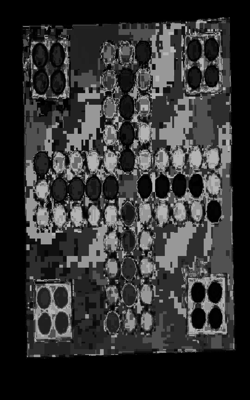

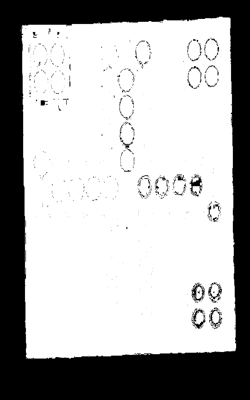

2  ((552.0, 519.5), (1039.7708740234375, 1058.755859375), 12.771366119384766) (44, 2, 1016, 1035)


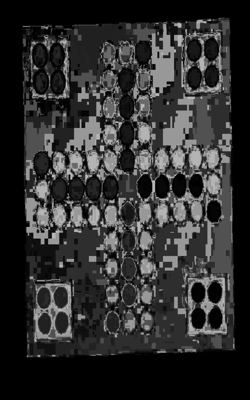

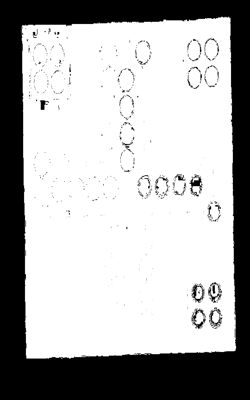

2  ((552.0, 519.5), (1039.1455078125, 1058.550537109375), 14.878358840942383) (49, 7, 1006, 1025)


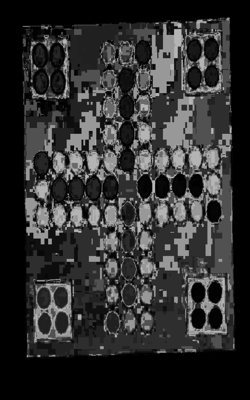

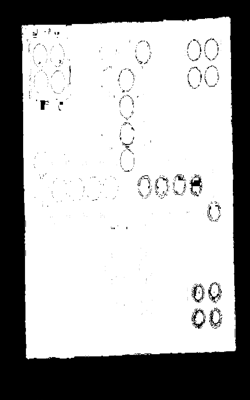

2  ((552.0, 519.5), (1039.4632568359375, 1058.7855224609375), 14.994715690612793) (49, 7, 1006, 1025)


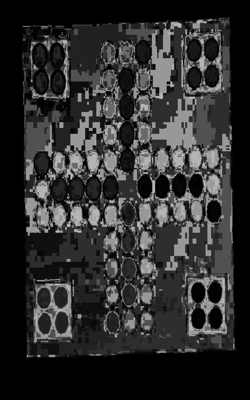

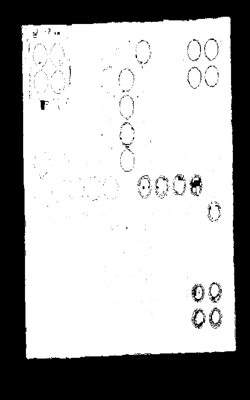

2  ((552.5, 519.5), (1038.956298828125, 1059.156494140625), 15.05056381225586) (50, 7, 1005, 1025)


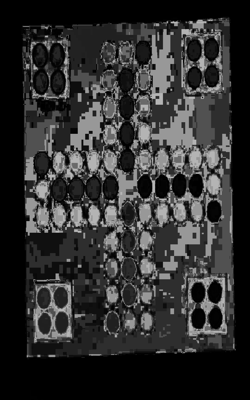

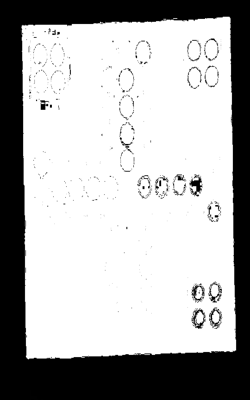

2  ((552.5, 519.5), (1039.6207275390625, 1059.8726806640625), 14.286151885986328) (48, 5, 1009, 1029)


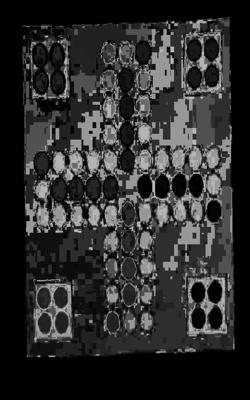

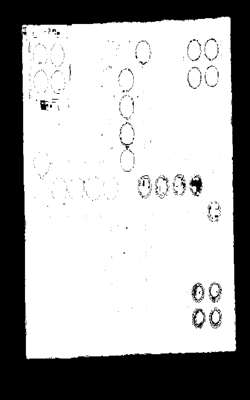

2  ((552.5, 519.0), (1039.0550537109375, 1059.814453125), 16.452253341674805) (53, 10, 999, 1018)


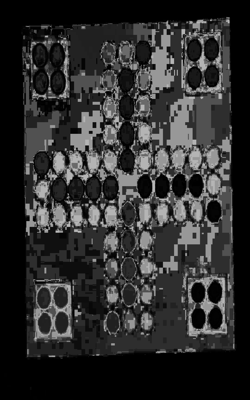

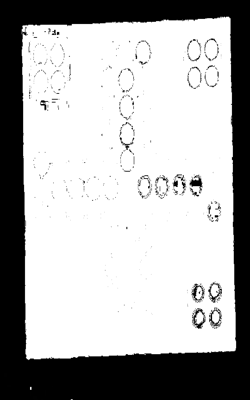

2  ((552.0, 519.0), (1039.565185546875, 1059.849609375), 16.174518585205078) (52, 9, 1000, 1020)


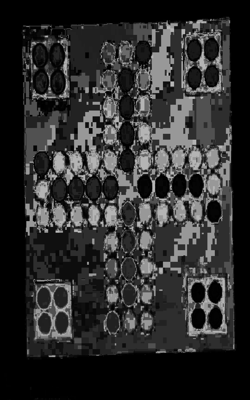

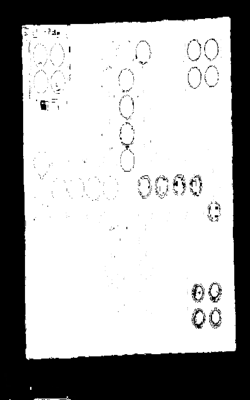

2  ((552.5, 519.0), (1039.0850830078125, 1059.5869140625), 16.434236526489258) (53, 10, 999, 1018)


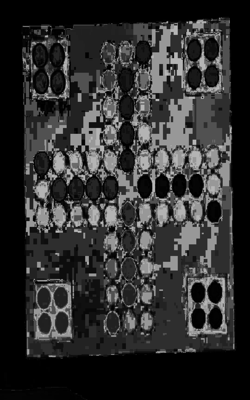

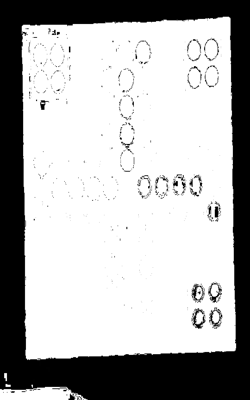

2  ((552.5, 519.5), (1039.0902099609375, 1059.914306640625), 17.451038360595703) (56, 13, 993, 1013)


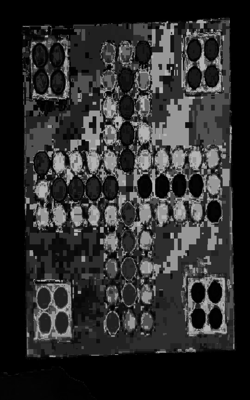

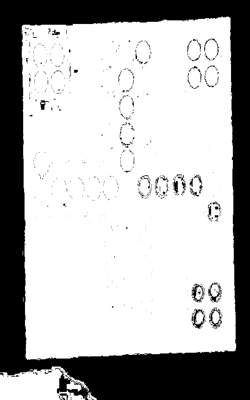

2  ((550.0, 521.0), (1037.3594970703125, 1070.6732177734375), 25.315017700195312) (80, 36, 940, 970)


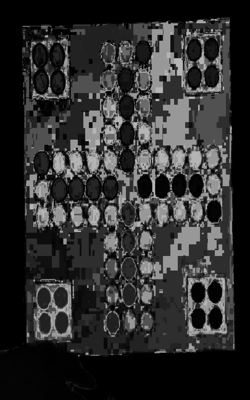

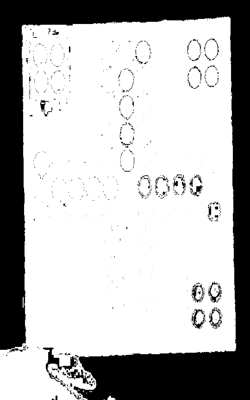

2  ((548.0, 523.0), (1036.7213134765625, 1077.705322265625), 29.485307693481445) (96, 53, 904, 940)


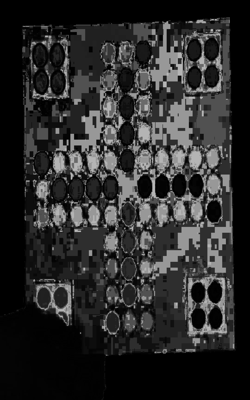

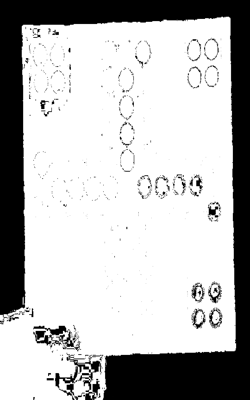

2  ((550.0, 520.0), (1035.42138671875, 1066.6575927734375), 27.097198486328125) (88, 44, 924, 952)


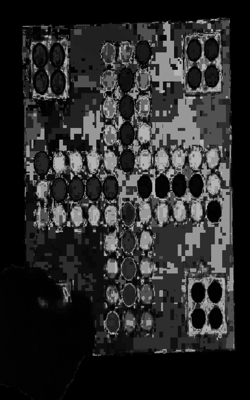

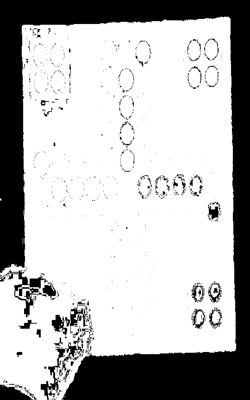

2  ((552.0, 517.0), (1043.232421875, 1061.12255859375), 21.048961639404297) (64, 21, 976, 992)


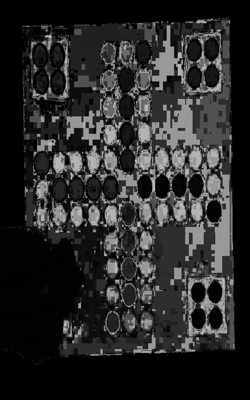

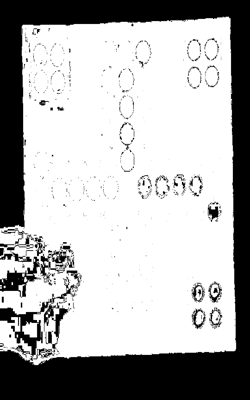

2  ((554.5, 527.5), (1046.6434326171875, 1056.205078125), 4.5691304206848145) (32, 0, 1045, 1055)


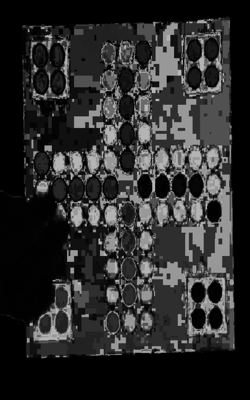

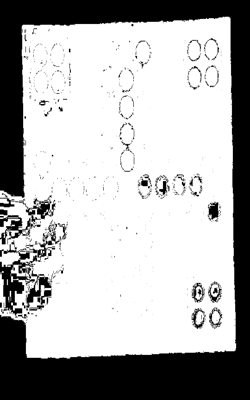

2  ((548.5, 519.0), (1048.1527099609375, 1066.3011474609375), 44.3944206237793) (173, 137, 751, 764)


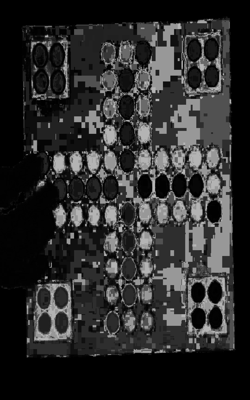

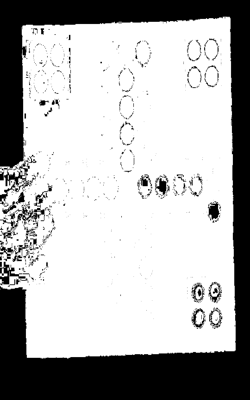

2  ((544.0, 517.0), (881.7462158203125, 907.0845947265625), 11.649447441101074) (111, 72, 866, 890)


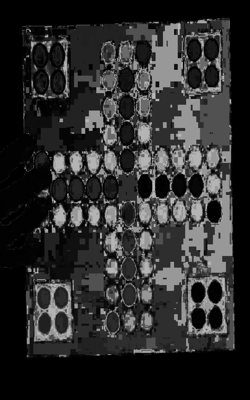

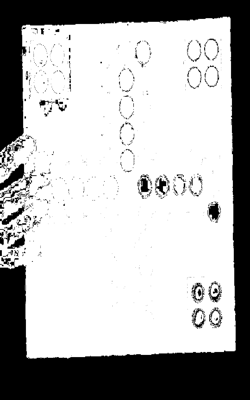

2  ((542.5, 520.5), (1009.208984375, 1049.0511474609375), 8.131416320800781) (42, 0, 1001, 1041)


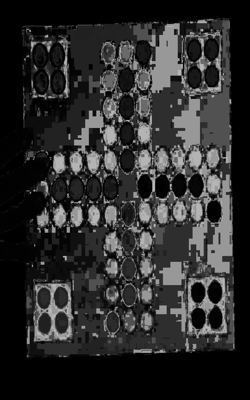

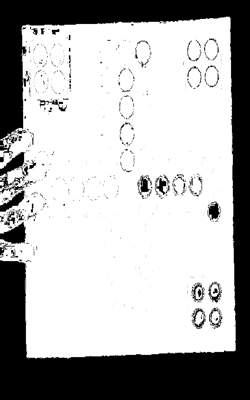

2  ((545.5, 520.0), (1044.9334716796875, 1063.0867919921875), 55.75338363647461) (105, 87, 881, 866)


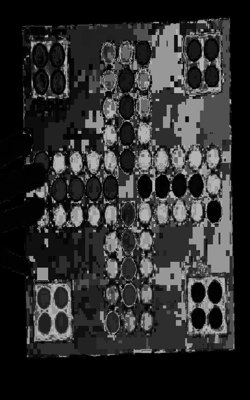

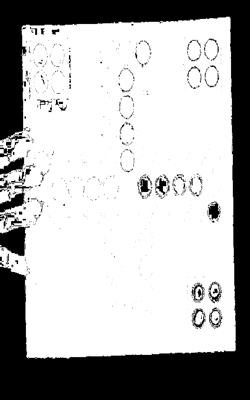

2  ((545.0, 519.5), (1020.9767456054688, 1026.7418212890625), 56.090824127197266) (118, 95, 854, 849)


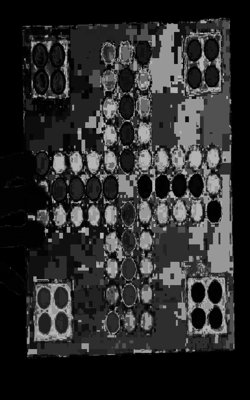

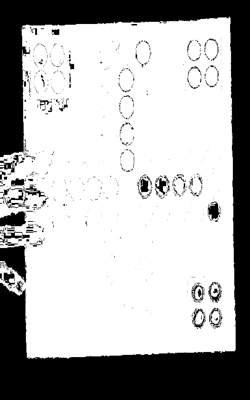

2  ((541.0, 519.0), (996.4279174804688, 1007.2944946289062), 28.7015438079834) (103, 76, 876, 886)


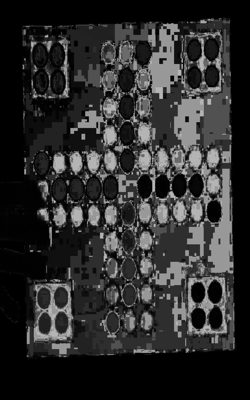

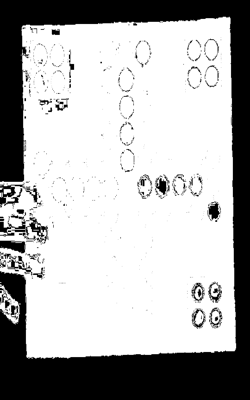

2  ((546.0, 521.5), (1015.0304565429688, 1046.0283203125), 5.549140930175781) (40, 0, 1012, 1043)


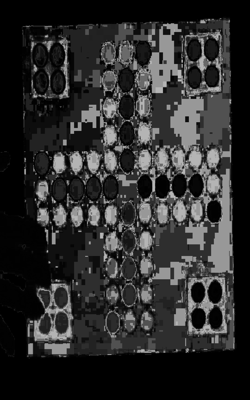

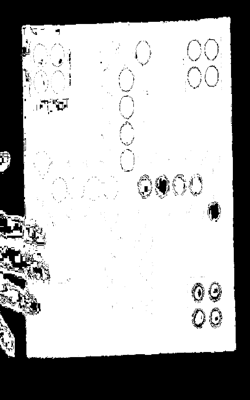

2  ((548.5, 521.0), (1039.769775390625, 1070.7841796875), 41.32540512084961) (157, 118, 783, 806)


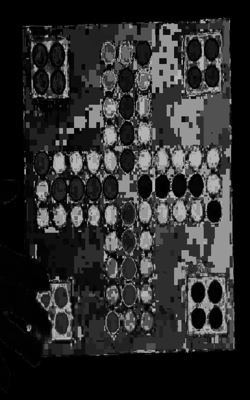

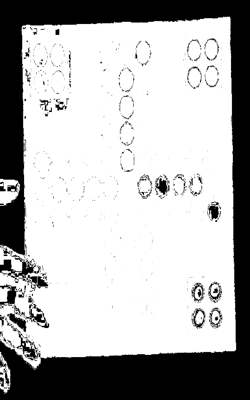

2  ((544.5, 518.5), (917.5051879882812, 951.6791381835938), 1.95592200756073) (85, 42, 919, 953)


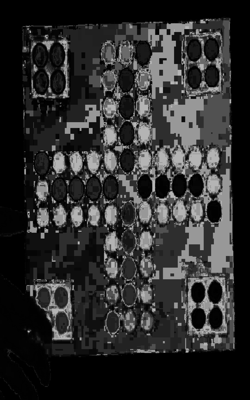

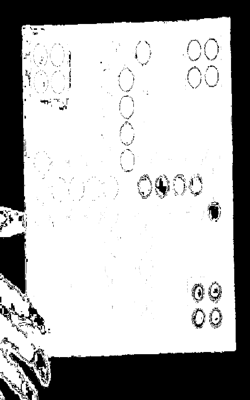

2  ((550.5, 520.5), (1039.8262939453125, 1064.9652099609375), 28.334415435791016) (92, 51, 917, 939)


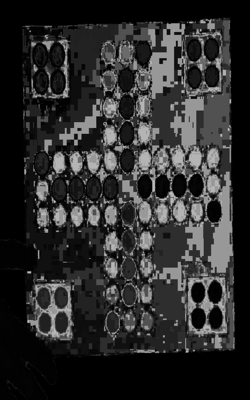

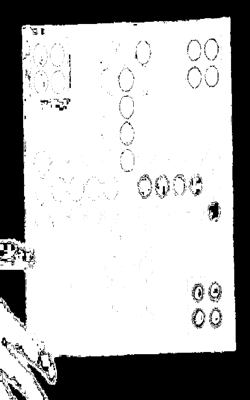

2  ((550.5, 521.5), (1037.703369140625, 1066.723388671875), 28.330583572387695) (93, 51, 915, 941)


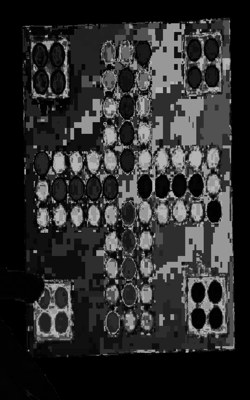

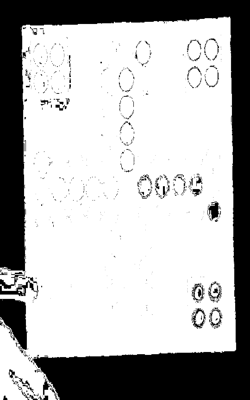

2  ((552.0, 520.5), (1037.6715087890625, 1062.2083740234375), 21.366491317749023) (68, 25, 968, 991)


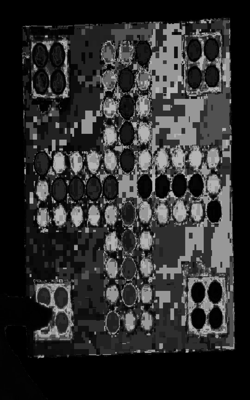

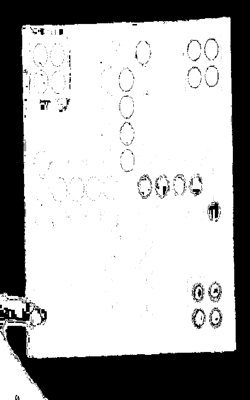

2  ((552.0, 520.5), (1037.9281005859375, 1063.5770263671875), 25.410308837890625) (82, 39, 940, 963)


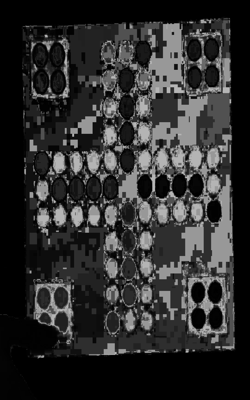

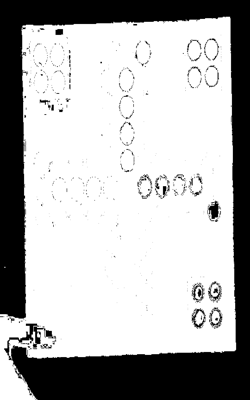

2  ((553.5, 518.5), (1038.404052734375, 1057.3934326171875), 15.429746627807617) (52, 8, 1003, 1021)


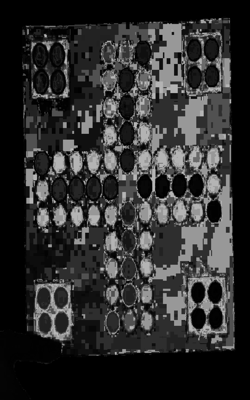

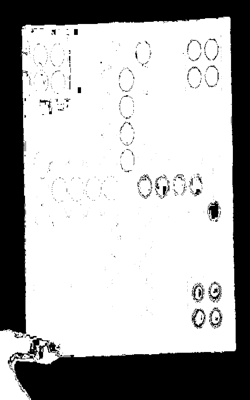

2  ((550.5, 521.5), (1037.741455078125, 1071.03369140625), 31.08220100402832) (105, 62, 891, 919)


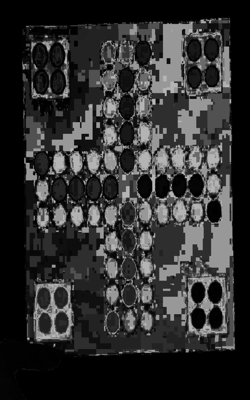

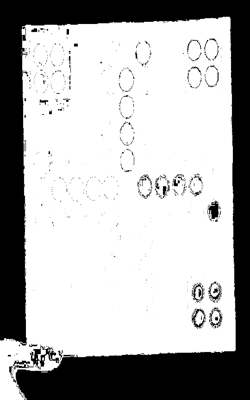

2  ((551.5, 517.0), (1029.5474853515625, 1058.17822265625), 20.716136932373047) (69, 21, 965, 992)


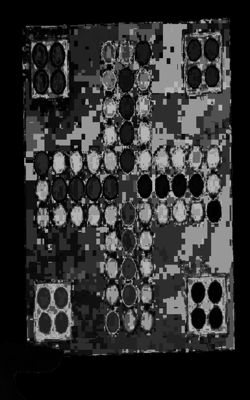

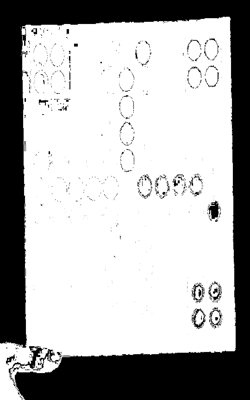

2  ((550.0, 522.5), (1034.56689453125, 1074.4920654296875), 29.356779098510742) (98, 53, 904, 939)


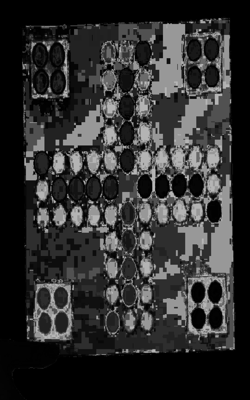

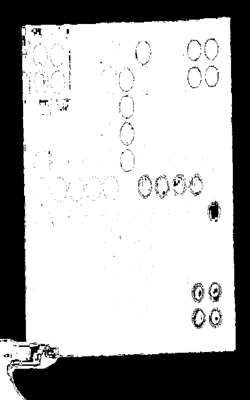

2  ((552.0, 518.0), (1034.942626953125, 1058.4315185546875), 19.757110595703125) (64, 19, 976, 998)


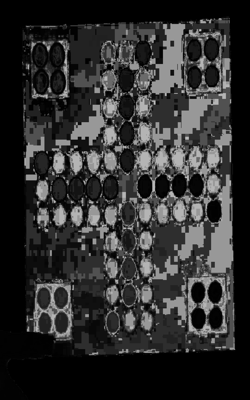

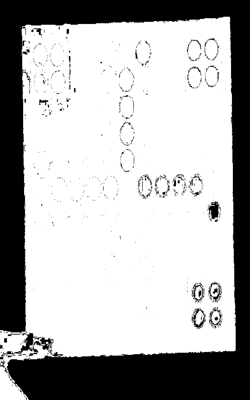

2  ((552.5, 519.5), (1037.7349853515625, 1059.934814453125), 22.785442352294922) (73, 30, 959, 979)


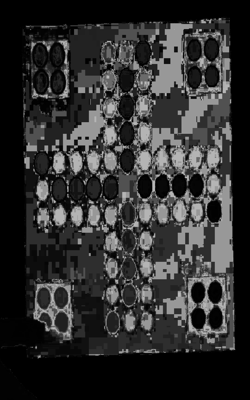

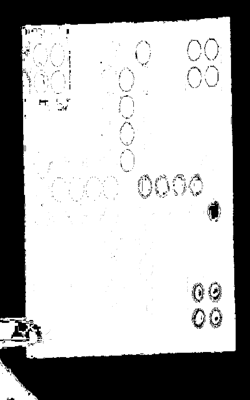

2  ((552.5, 519.5), (1037.1934814453125, 1058.3916015625), 17.529638290405273) (57, 14, 991, 1011)


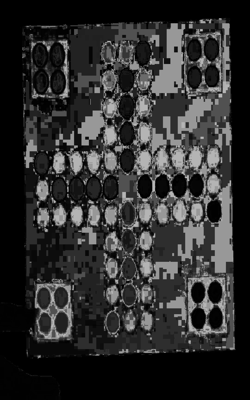

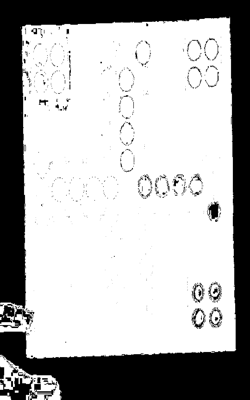

2  ((550.0, 521.0), (1036.829833984375, 1066.2994384765625), 28.144132614135742) (92, 50, 916, 942)


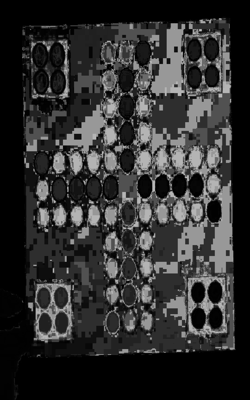

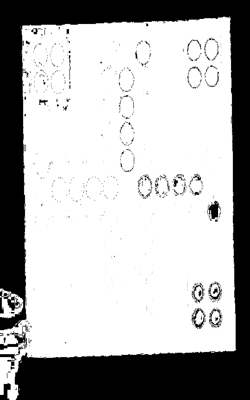

2  ((551.5, 520.5), (1037.4893798828125, 1061.82177734375), 23.26523780822754) (74, 32, 955, 977)


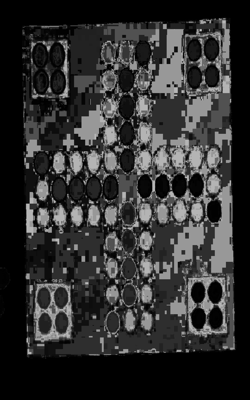

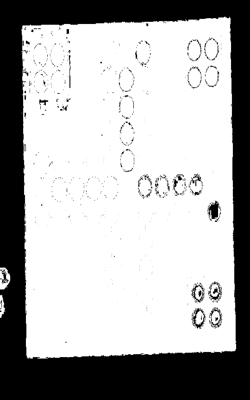

2  ((553.5, 519.0), (1036.7774658203125, 1058.097412109375), 14.17116928100586) (50, 5, 1007, 1028)


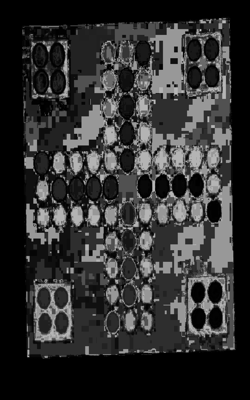

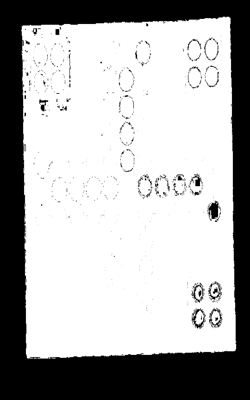

2  ((553.5, 519.0), (1036.5584716796875, 1058.500732421875), 14.636255264282227) (51, 6, 1005, 1026)


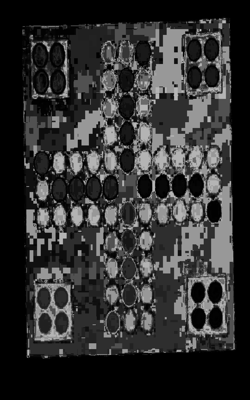

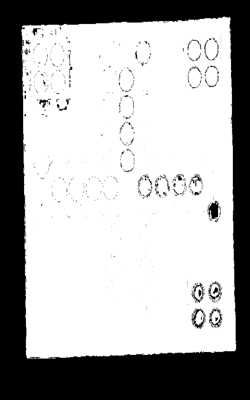

2  ((553.0, 519.5), (1036.154541015625, 1058.28466796875), 16.01236915588379) (54, 10, 998, 1019)


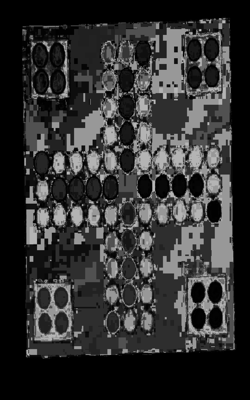

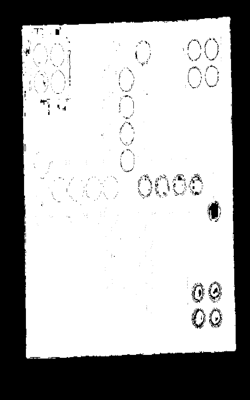

2  ((552.0, 519.0), (1037.2431640625, 1058.2261962890625), 14.935359001159668) (50, 7, 1004, 1024)


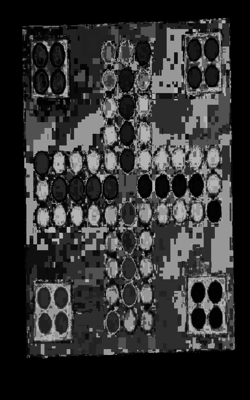

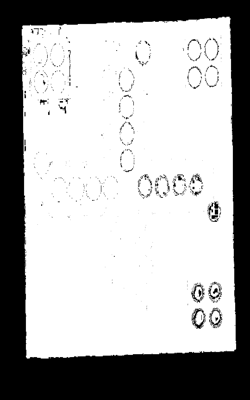

2  ((553.5, 519.5), (1037.1339111328125, 1057.7403564453125), 15.166386604309082) (52, 8, 1003, 1023)


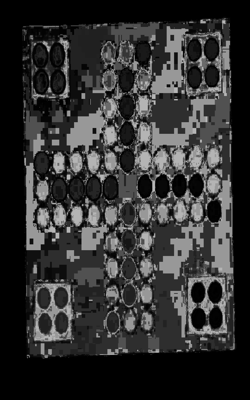

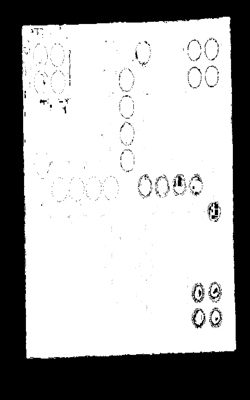

2  ((552.0, 519.5), (1038.10693359375, 1057.8121337890625), 13.837621688842773) (47, 5, 1010, 1029)


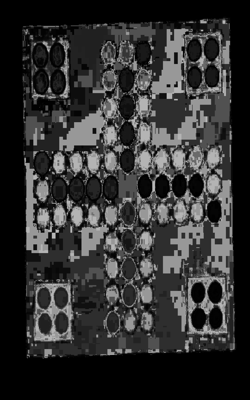

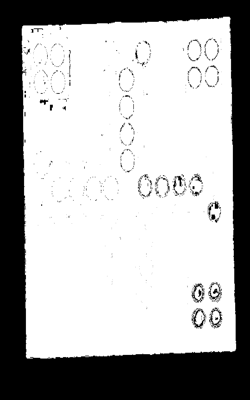

2  ((553.0, 519.5), (1038.244384765625, 1057.6268310546875), 14.25568675994873) (49, 6, 1008, 1027)


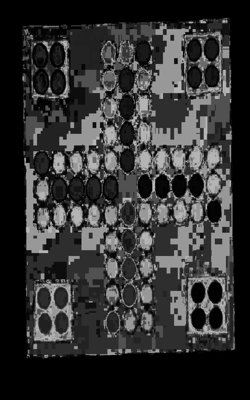

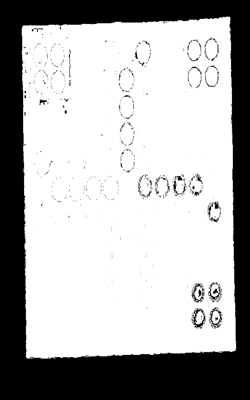

2  ((553.0, 519.0), (1038.829345703125, 1057.5396728515625), 12.993145942687988) (46, 3, 1014, 1032)


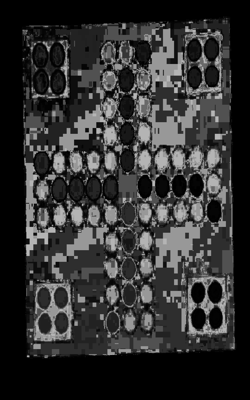

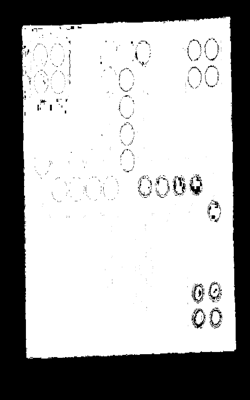

2  ((553.0, 519.5), (1038.0262451171875, 1057.606689453125), 15.560453414916992) (52, 9, 1002, 1021)


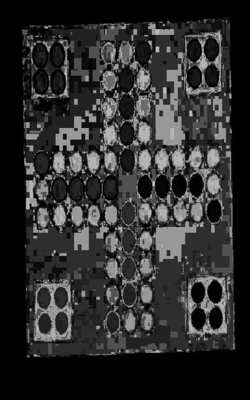

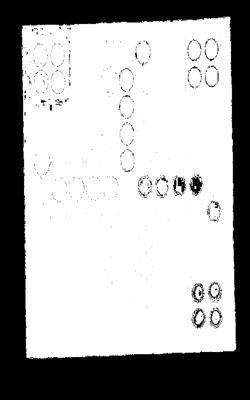

2  ((552.0, 518.0), (1038.65625, 1058.8623046875), 13.04633617401123) (45, 1, 1014, 1034)


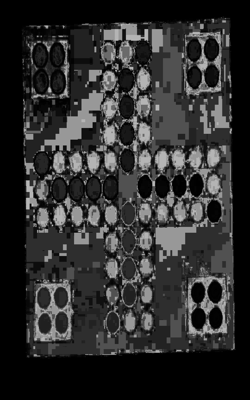

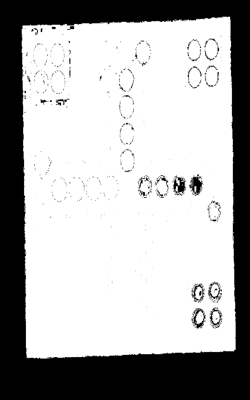

2  ((552.0, 518.5), (1038.9932861328125, 1059.147216796875), 14.542025566101074) (48, 5, 1008, 1027)


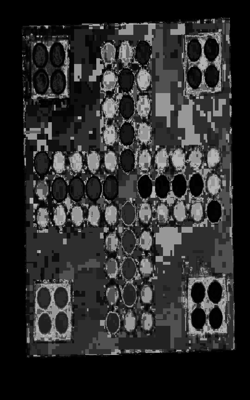

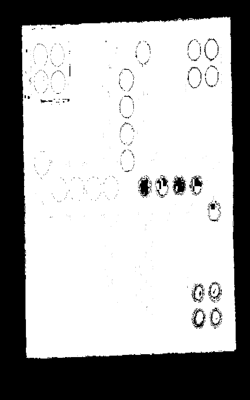

2  ((552.5, 520.5), (1040.5794677734375, 1060.6898193359375), 11.675533294677734) (42, 0, 1021, 1041)


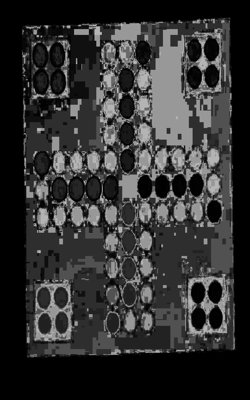

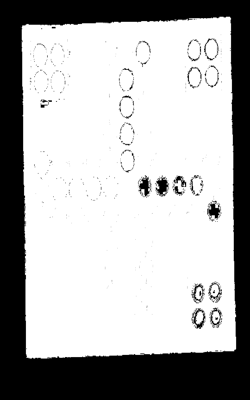

2  ((552.0, 521.0), (1042.067138671875, 1061.2381591796875), 11.399706840515137) (40, 0, 1024, 1042)


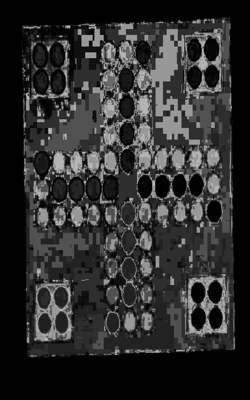

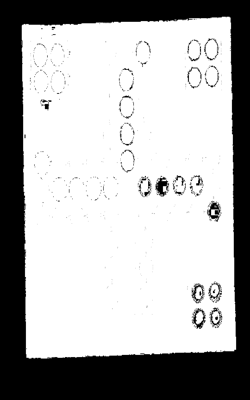

2  ((552.5, 519.0), (1041.03466796875, 1060.7069091796875), 12.45015811920166) (43, 0, 1019, 1038)


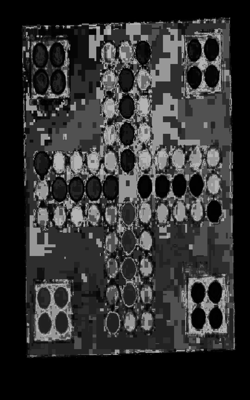

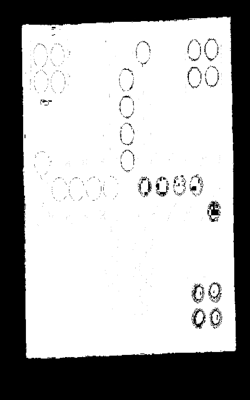

2  ((552.0, 519.5), (1041.2044677734375, 1060.150634765625), 12.097579956054688) (42, 0, 1020, 1039)


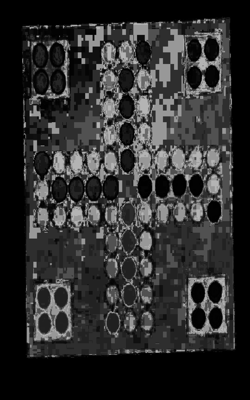

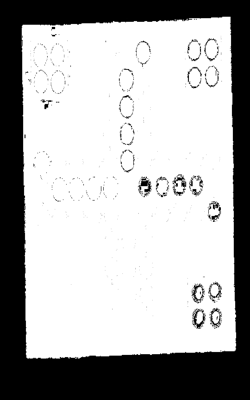

2  ((552.5, 518.0), (1041.6180419921875, 1060.5084228515625), 12.914413452148438) (44, 0, 1017, 1036)


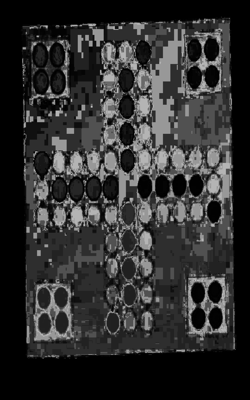

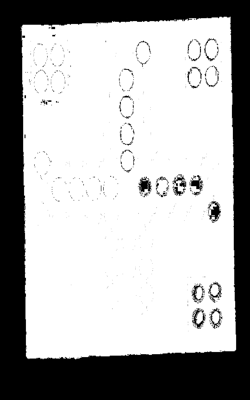

2  ((552.0, 519.0), (1041.4327392578125, 1061.7672119140625), 12.765892028808594) (43, 0, 1018, 1038)


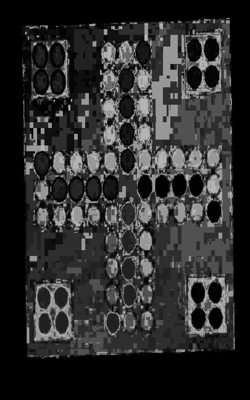

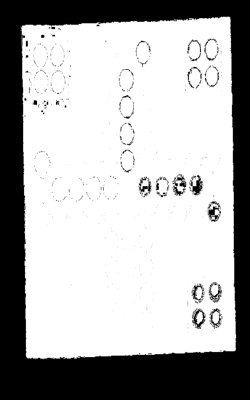

2  ((552.5, 518.0), (1039.7020263671875, 1061.435546875), 15.220088958740234) (50, 5, 1005, 1026)


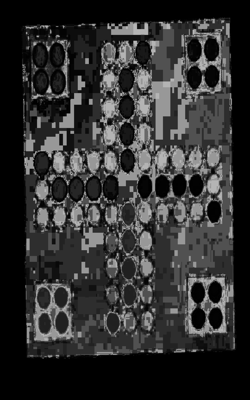

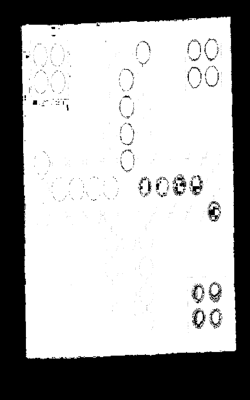

2  ((552.5, 518.5), (1040.9344482421875, 1061.5657958984375), 13.710267066955566) (46, 2, 1013, 1033)


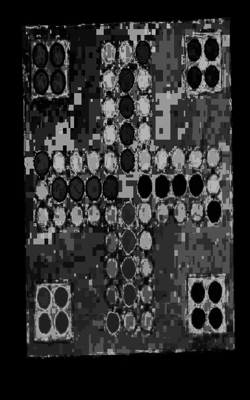

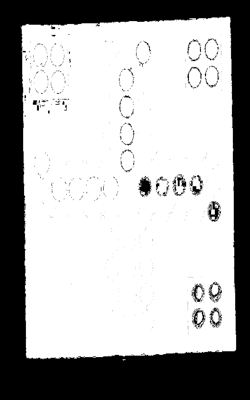

2  ((552.5, 518.5), (1040.47900390625, 1062.3092041015625), 13.598160743713379) (46, 1, 1013, 1035)


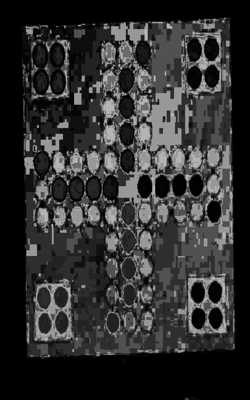

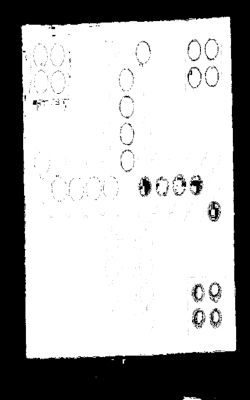

2  ((552.0, 521.5), (1040.5986328125, 1062.073974609375), 11.427399635314941) (41, 0, 1022, 1043)


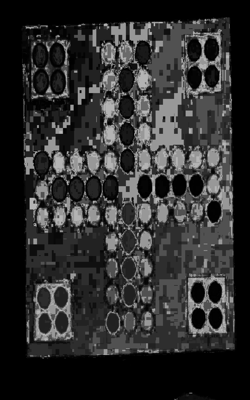

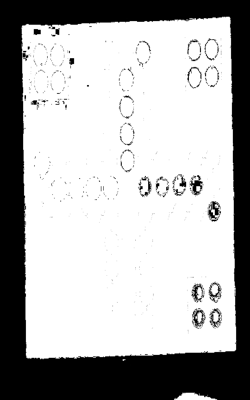

2  ((553.5, 519.5), (1038.544189453125, 1061.38232421875), 15.408811569213867) (52, 7, 1003, 1025)


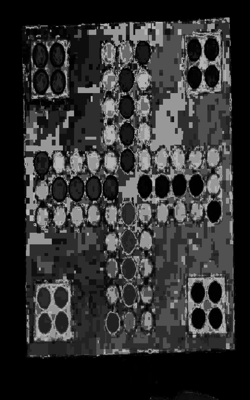

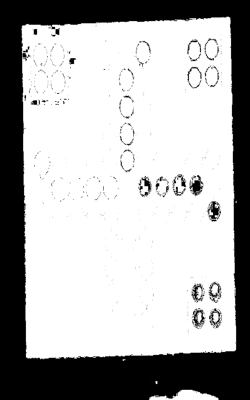

2  ((553.5, 519.5), (1039.3267822265625, 1061.7607421875), 14.23586368560791) (49, 4, 1009, 1031)


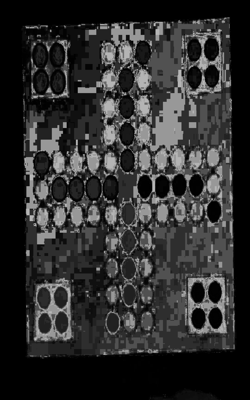

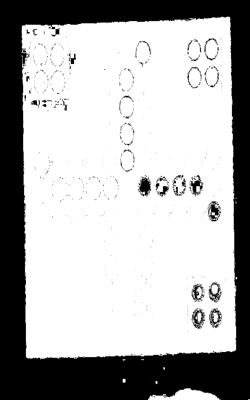

2  ((553.5, 519.0), (1038.5701904296875, 1062.669677734375), 15.516355514526367) (52, 6, 1003, 1026)


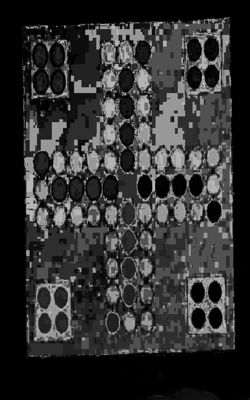

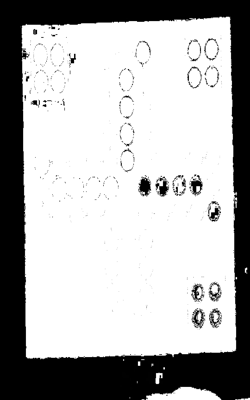

2  ((553.0, 522.0), (1041.0657958984375, 1063.3890380859375), 11.633227348327637) (42, 0, 1022, 1044)


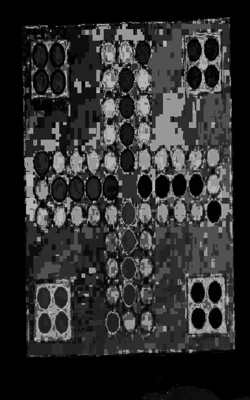

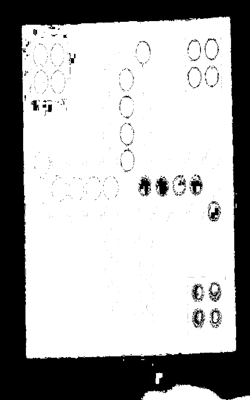

2  ((554.0, 525.0), (1040.29541015625, 1064.4703369140625), 10.217585563659668) (41, 0, 1026, 1050)


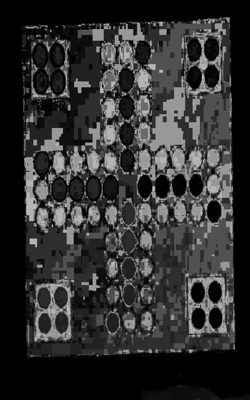

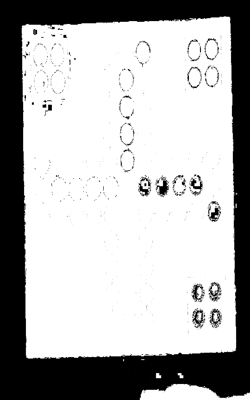

2  ((554.5, 532.5), (1041.63134765625, 1065.69091796875), 3.8311057090759277) (34, 0, 1041, 1065)


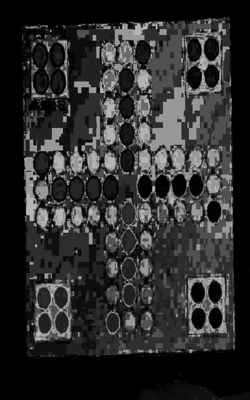

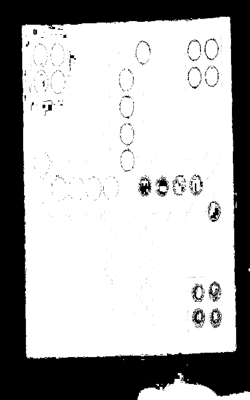

2  ((556.5, 534.0), (1040.64013671875, 1079.533935546875), 170.80906677246094) (42, 0, 1029, 1068)


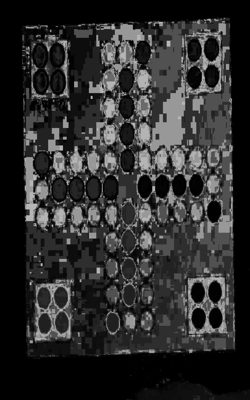

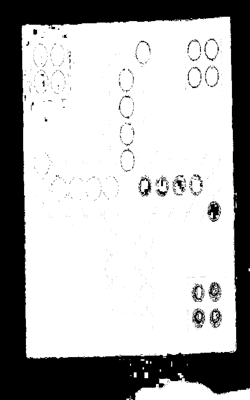

2  ((557.5, 530.5), (1038.8817138671875, 1090.260009765625), 166.14698791503906) (52, 0, 1011, 1061)


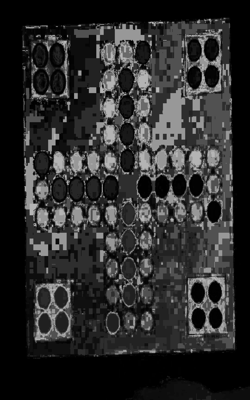

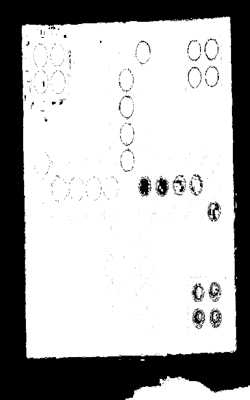

2  ((556.5, 529.5), (1040.714111328125, 1085.5023193359375), 166.86048889160156) (49, 0, 1015, 1059)


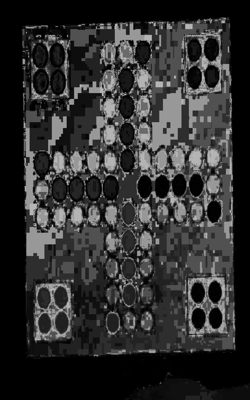

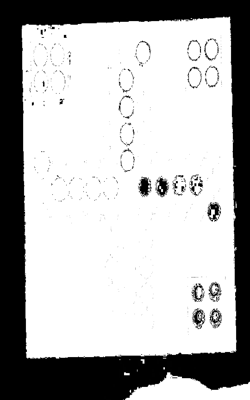

2  ((556.0, 527.5), (1040.58056640625, 1089.4871826171875), 164.7423553466797) (53, 1, 1006, 1053)


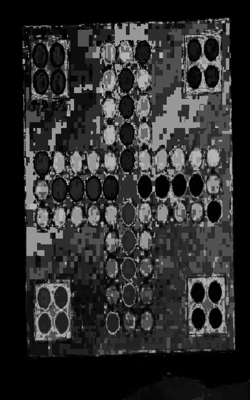

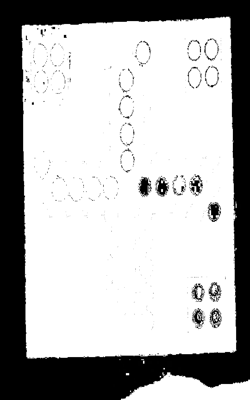

2  ((556.5, 526.0), (1040.842529296875, 1087.148193359375), 165.015380859375) (53, 0, 1007, 1052)


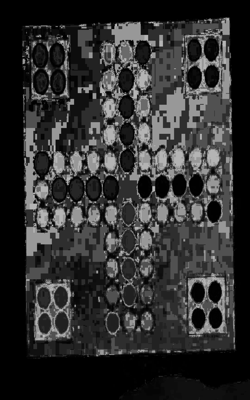

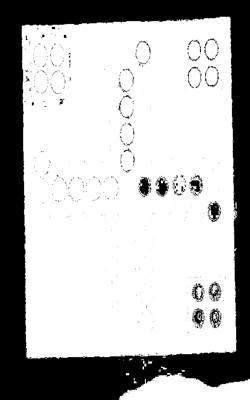

2  ((556.5, 527.5), (1040.38818359375, 1089.736572265625), 165.0583038330078) (53, 0, 1007, 1055)


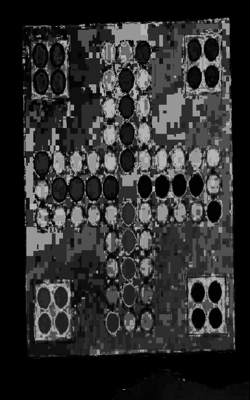

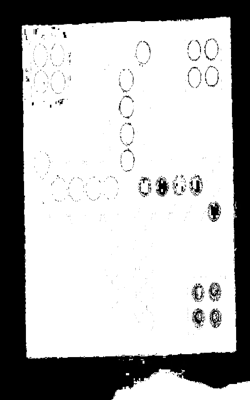

2  ((557.5, 533.5), (1037.7333984375, 1093.296875), 166.92919921875) (51, 0, 1013, 1067)


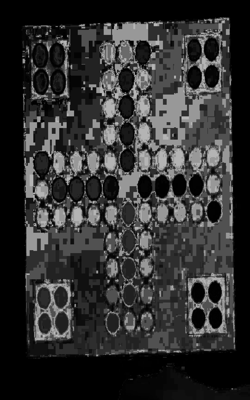

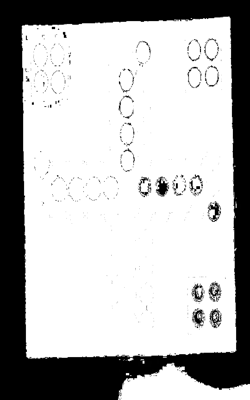

2  ((559.0, 538.0), (1033.4605712890625, 1114.3037109375), 164.54531860351562) (60, 0, 998, 1076)


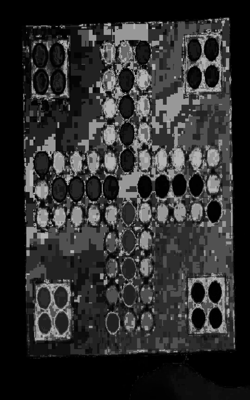

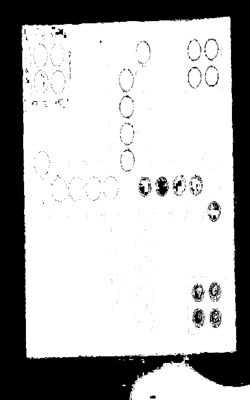

2  ((562.5, 539.0), (1030.5771484375, 1129.6923828125), 160.7052001953125) (75, 5, 975, 1068)


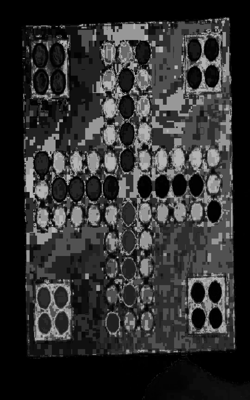

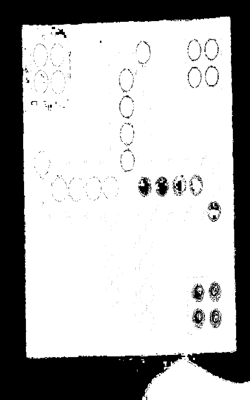

2  ((562.5, 536.5), (1033.372314453125, 1122.80322265625), 157.78858947753906) (83, 16, 959, 1041)


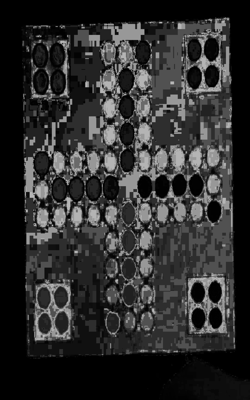

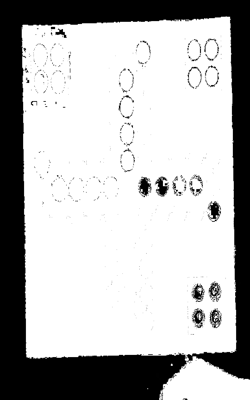

2  ((559.5, 528.0), (1039.9654541015625, 1095.044677734375), 157.2985382080078) (79, 22, 961, 1012)


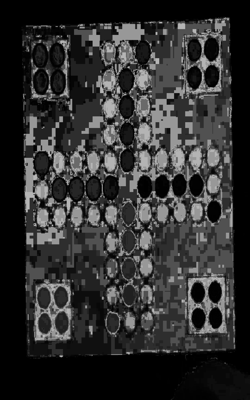

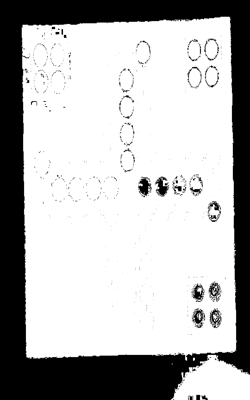

2  ((557.0, 525.0), (1043.7989501953125, 1081.9266357421875), 156.95326232910156) (76, 26, 962, 998)


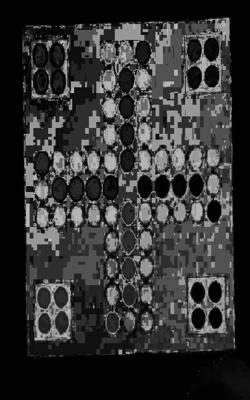

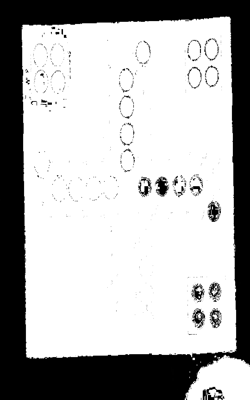

2  ((557.0, 523.0), (1045.5589599609375, 1075.30859375), 158.66453552246094) (69, 21, 976, 1004)


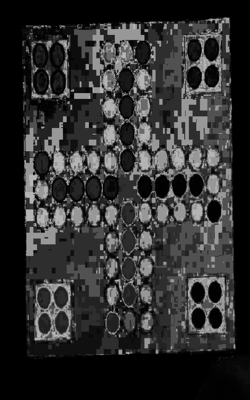

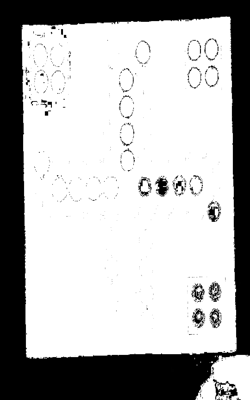

2  ((557.0, 523.5), (1046.3748779296875, 1073.6929931640625), 157.71310424804688) (72, 26, 970, 995)


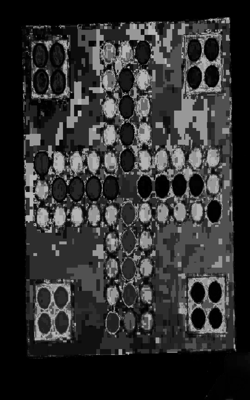

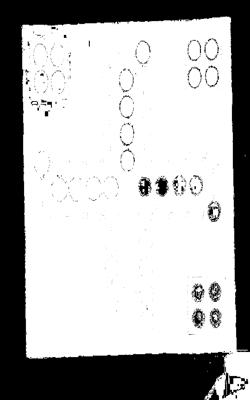

2  ((556.0, 521.5), (1047.7454833984375, 1067.6309814453125), 163.80821228027344) (52, 8, 1008, 1027)


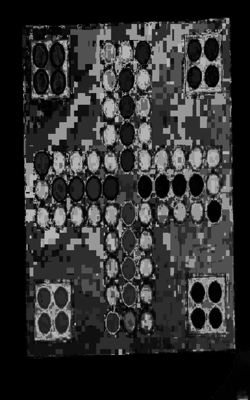

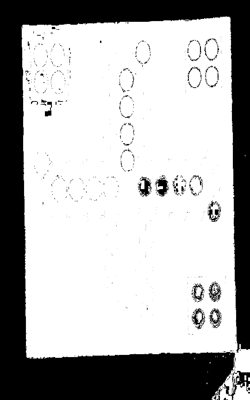

2  ((556.0, 521.5), (1047.738037109375, 1068.1004638671875), 160.57777404785156) (61, 17, 990, 1009)


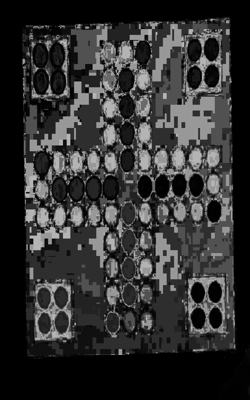

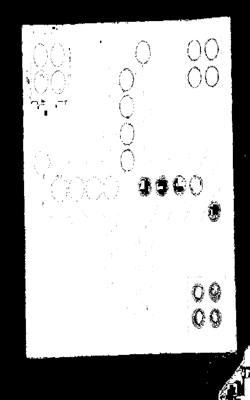

2  ((553.5, 531.5), (1045.0596923828125, 1061.57568359375), 0.9073655009269714) (30, 0, 1047, 1063)


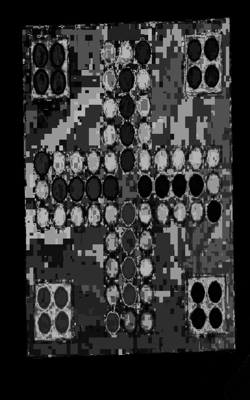

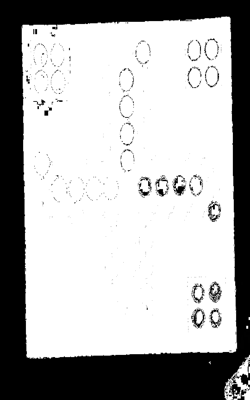

2  ((556.5, 521.5), (1046.6021728515625, 1068.8616943359375), 159.84532165527344) (64, 19, 985, 1005)


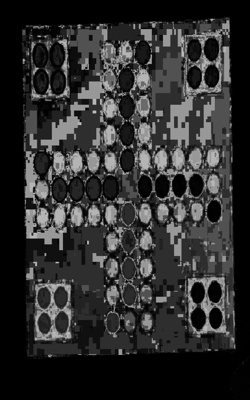

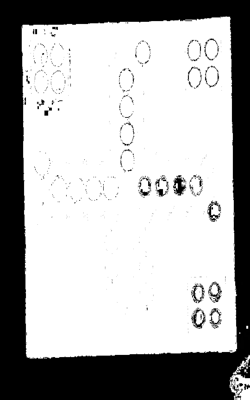

2  ((554.0, 527.5), (1043.3345947265625, 1059.5791015625), 6.5969438552856445) (35, 0, 1038, 1055)


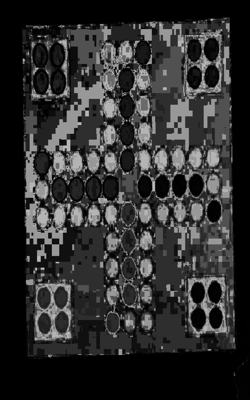

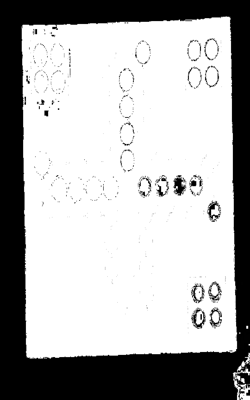

2  ((555.0, 525.5), (1046.054931640625, 1063.40869140625), 170.5773468017578) (38, 0, 1034, 1051)


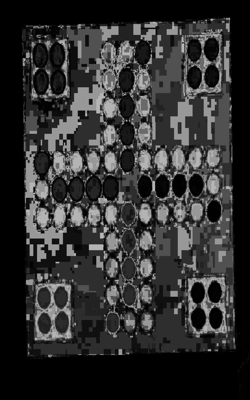

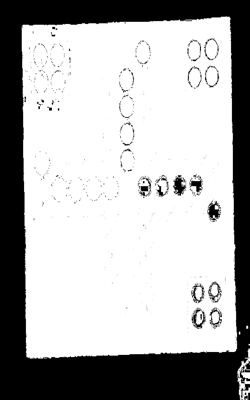

2  ((554.5, 520.5), (1046.571533203125, 1065.0894775390625), 166.7378692626953) (44, 1, 1021, 1039)


In [284]:
board_track = cv2.VideoWriter('./slow_board_small_camshift.avi', cv2.VideoWriter_fourcc(*'DIVX'), board_fps, (board_width, board_height))
EDGE = 1100
track_window = (x, y, w, h)
track_window0 = track_window1 = track_window2 =track_window
it = 0
board.set(cv2.CAP_PROP_POS_FRAMES, 0)
hist_prev = None
while board.isOpened() and it < 100:
    ret, frame = board.read()
    it += 1
    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        hsv = hsv[:EDGE, :, :]
       # hist = cv2.histogram(hsv)
        dst0 = cv2.calcBackProject([hsv], [0], roi_hist_0, [0,180], 1)
        imshow( dst0)
        dst0[dst0 > 1] =255
        imshow( dst0)
        #imshow(dst2)
        #print(dst2.shape)
        ret2, track_window2 = cv2.CamShift(dst0, track_window2, term_crit)
        print("2 ", ret2, track_window2)

        pts2 = np.int0(cv2.boxPoints(ret2))
        board_track.write(cv2.polylines(frame, [pts2], True, 30, 3))
    else:
        break
board_track.release()

In [285]:
!!ffmpeg -hide_banner -loglevel error -i slow_board_small_camshift.avi -y slow_board_small_camshift.mp4

[]

In [286]:
Video.from_file('./slow_board_small_camshift.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')